In [13]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import imutils
import albumentations as A
import torch
import numpy as np
import segmentation_models_pytorch as smp
import cv2
import matplotlib.pyplot as plt
import json
import random

from segmentation_models_pytorch import utils as smp_utils
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from tqdm.notebook import tqdm

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
torch.cuda.empty_cache()

In [4]:
DATA_DIR = 'src/data/'
images_dir = os.path.join(DATA_DIR, 'images')
masks_dir = os.path.join(DATA_DIR, 'masks')

In [5]:
images = sorted(os.listdir(os.path.join(DATA_DIR, 'images')))
len(images)

228

In [6]:
masks = sorted(os.listdir(os.path.join(DATA_DIR, 'masks')))
len(masks)

228

In [30]:
images[7], masks[7]

('20230225_124022.jpg', '20230225_124022.png')

In [67]:
img = cv2.imread(os.path.join(DATA_DIR, 'masks', '20230223_203409.png'), 0)
np.unique(img)

array([  0, 193], dtype=uint8)

In [8]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title(), fontsize=18)
        plt.imshow(image)
    plt.show()

In [9]:
checkpoint_dir = 'checkpoints/fpn_mobilenetv2_512im_bce_v2'
IM_SIZE=(512, 512)
BATCH_SIZE = 8
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['receipt']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [76]:

class Dataset(BaseDataset):

    def __init__(
            self,
            images_list,
            masks_list,
            images_dir,
            masks_dir,
            im_size=(1024, 1024),
            augmentation=None,
            preprocessing=None,
    ):
        self.im_size = im_size
        self.images_ids = images_list
        self.masks_ids = masks_list
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.images_ids]
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.masks_ids]

        self.class_values = [86]
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        mask = cv2.imread(self.masks_fps[i], 0)

        # print(self.images_fps[i], self.masks_fps[i])
        if image.shape[0] != mask.shape[0]:
            # image = imutils.rotate(image, angle=90)
            image = cv2.flip(image.transpose(1, 0, 2), 0)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.im_size, interpolation=cv2.INTER_AREA)

        mask = cv2.resize(mask, self.im_size, interpolation=cv2.INTER_AREA)
        mask = np.expand_dims(mask, axis=2).astype('float')
        mask[mask > 0] = 1

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.images_ids)

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(images, masks, test_size=0.2, random_state = SEED)
# X_valid, X_test, y_valid, y_test = train_test_split(X_valid, X_valid, test_size=0.5, random_state = SEED)
print(f"Train: {len(X_train), len(y_train)}")
print(f"Valid: {len(X_valid), len(y_valid)}")

print(f"7th element: {X_train[7], y_train[7]}")

Train: (182, 182)
Valid: (46, 46)
7th element: ('20230225_132108.jpg', '20230225_132108.png')


src/data/images/20230225_132209.jpg src/data/masks/20230225_132209.png


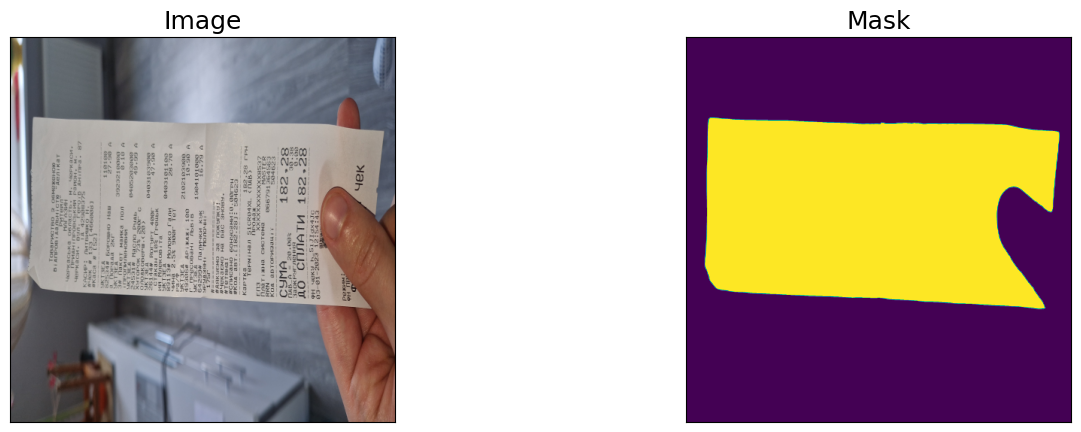

In [58]:
dataset = Dataset(X_train, y_train, images_dir, masks_dir, im_size=IM_SIZE)

image, mask = dataset[25] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

In [80]:
def get_training_augmentation():
    train_transform = [
        A.Flip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.1, p=1, border_mode=0),
#         A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
#         A.RandomCrop(height=896, width=896, always_apply=True),
        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """
    add paddings to make image shape divisible by 32
    """
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)


def to_tensor(x, **kwargs):
    if len(x.shape) == 3:
        return x.transpose(2, 0, 1).astype('float32')
    else:
        return x.astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

src/data/images/20230225_123917.jpg src/data/masks/20230225_123917.png


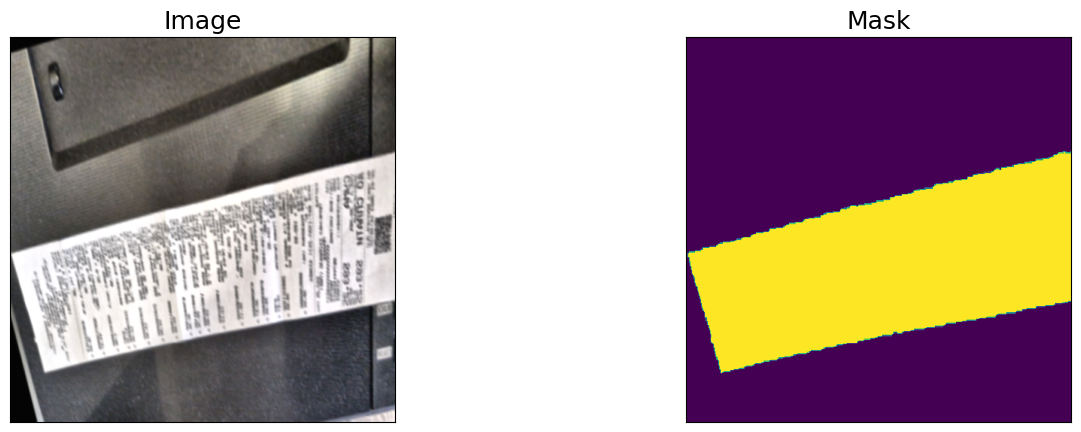

src/data/images/20230225_123917.jpg src/data/masks/20230225_123917.png


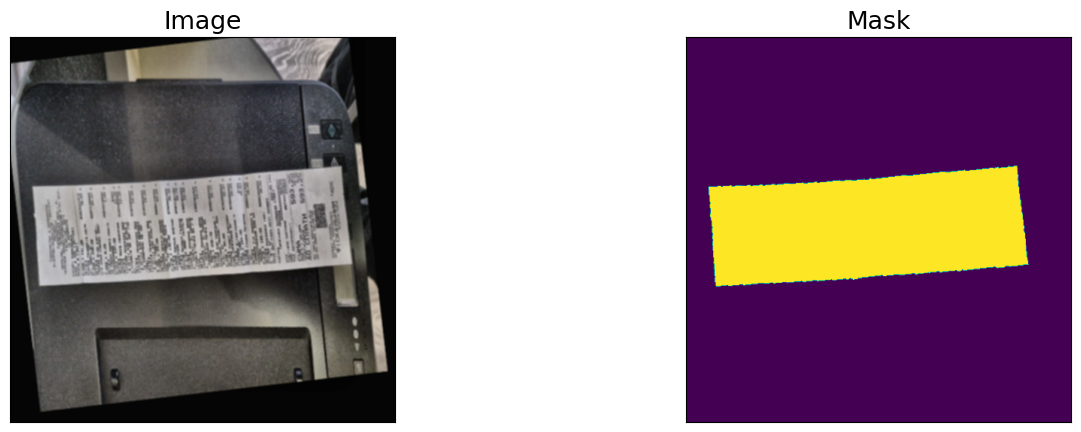

src/data/images/20230225_123917.jpg src/data/masks/20230225_123917.png


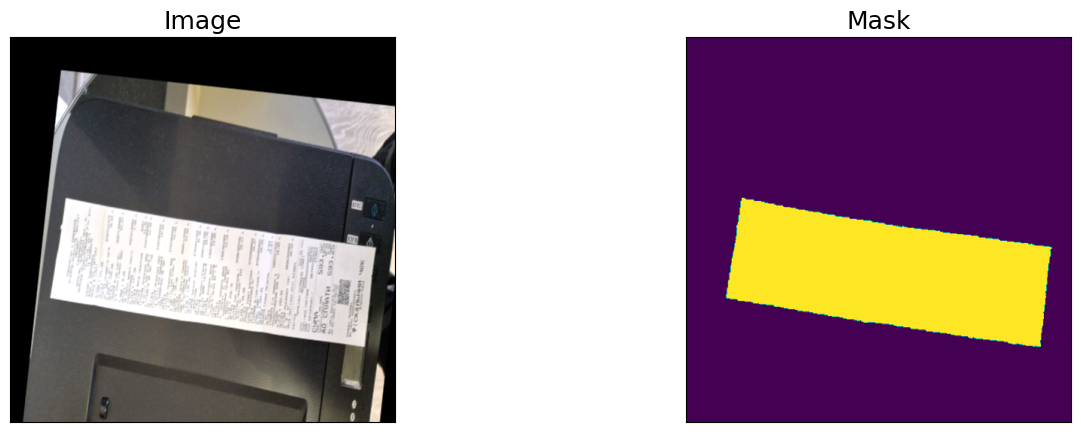

In [61]:
# Dataset(images, images_dir, masks_dir, )
augmented_dataset = Dataset(
    images,
    masks,
    images_dir,
    masks_dir,
    im_size=IM_SIZE,
    augmentation=get_training_augmentation(), 
)

for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask)

In [62]:
train_dataset = Dataset(
    X_train,
    y_train,
    images_dir,
    masks_dir,
    im_size=IM_SIZE,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
#     classes=CLASSES,
)

valid_dataset = Dataset(
    X_valid,
    y_valid,
    images_dir,
    masks_dir,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
#     classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=12)

/home/vdubyna/PycharmProjects/ukrReceipts/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [63]:
loss = smp_utils.losses.BCELoss()
metrics = [
    smp_utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters()), #, lr=0.0001
])

In [64]:
lambda1 = lambda epoch: 0.93 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

In [65]:
train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [66]:
max_score = 0
lrs = []
train_loss = []
train_iou = []
val_loss = []
val_iou = []

for epoch in range(0, 50):
    
    print(f"\nEpoch: {epoch+1}")
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    lrs.append(optimizer.param_groups[0]['lr'])
    train_loss.append(train_logs['bce_loss'])
    train_iou.append(train_logs['iou_score'])
    val_loss.append(valid_logs['bce_loss'])
    val_iou.append(valid_logs['iou_score'])
    scheduler.step()
    
    if max_score < valid_logs['iou_score']:
        print(f"=> [On epoch {epoch+1:03d}] best IOU was improved from {max_score:.3f} to {valid_logs['iou_score']:.3f}")
        max_score = valid_logs['iou_score']
        torch.save(
            {
                'epoch': epoch + 1,
                'arch': 'FPN + mobilenet_v2',
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            },
            str(os.path.join(checkpoint_dir, f"epoch{epoch:03d}_IOU({valid_logs['iou_score']:.3f})_bce_loss({valid_logs['bce_loss']:.4f}).pth"))
        )
        print('Model saved!')
    else:
        print(f"=> [On epoch {epoch+1:03d}] best IOU was not improved from {max_score:.3f} ({valid_logs['iou_score']:.3f})")


Epoch: 1
train:   0%|          | 0/23 [00:00<?, ?it/s]src/data/images/20230225_124456.jpg src/data/masks/20230225_124456.png
src/data/images/20230225_131647.jpg src/data/images/20230225_125215.jpgsrc/data/images/20230225_125030.jpgsrc/data/masks/20230225_131647.pngsrc/data/images/20230225_124245.jpg  src/data/masks/20230225_124245.png
 src/data/masks/20230225_125030.pngsrc/data/images/20230225_130548.jpg
src/data/masks/20230225_125215.png src/data/masks/20230225_130548.png

src/data/images/20230225_123957.jpgsrc/data/images/20230225_124403.jpgsrc/data/images/20230225_130314.jpg   src/data/masks/20230225_124403.png
src/data/masks/20230225_123957.png
src/data/masks/20230225_130314.png

src/data/images/20230225_131853.jpgsrc/data/images/20230225_125935.jpg  src/data/masks/20230225_131853.pngsrc/data/masks/20230225_125935.png

src/data/images/20230225_132044.jpg src/data/masks/20230225_132044.png
train:   0%|          | 0/23 [00:01<?, ?it/s]src/data/images/20230225_125823.jpg
 src/data/im

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/vdubyna/PycharmProjects/ukrReceipts/venv/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/vdubyna/PycharmProjects/ukrReceipts/venv/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/vdubyna/PycharmProjects/ukrReceipts/venv/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_35364/3950614830.py", line 46, in __getitem__
    sample = self.preprocessing(image=image, mask=mask)
  File "/home/vdubyna/PycharmProjects/ukrReceipts/venv/lib/python3.8/site-packages/albumentations/core/composition.py", line 205, in __call__
    data = t(**data)
  File "/home/vdubyna/PycharmProjects/ukrReceipts/venv/lib/python3.8/site-packages/albumentations/core/transforms_interface.py", line 118, in __call__
    return self.apply_with_params(params, **kwargs)
  File "/home/vdubyna/PycharmProjects/ukrReceipts/venv/lib/python3.8/site-packages/albumentations/core/transforms_interface.py", line 131, in apply_with_params
    res[key] = target_function(arg, **dict(params, **target_dependencies))
  File "/home/vdubyna/PycharmProjects/ukrReceipts/venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py", line 1652, in apply_to_mask
    return fn(mask, **params)
  File "/tmp/ipykernel_35364/1181544338.py", line 47, in to_tensor
    return x.transpose(2, 0, 1).astype('float32')
ValueError: axes don't match array


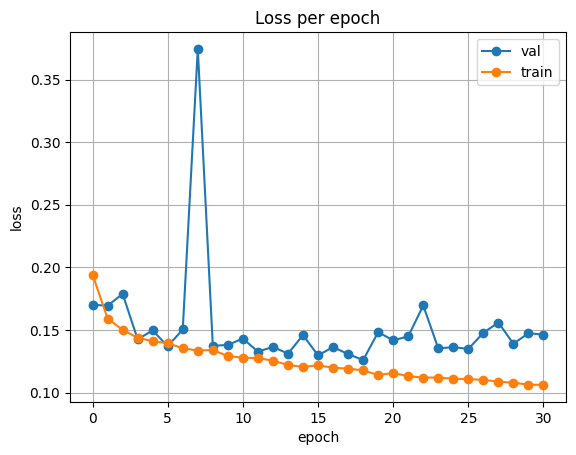

In [29]:
plt.plot(val_loss, label='val', marker='o')
plt.plot(train_loss, label='train', marker='o')
plt.title('Loss per epoch'); plt.ylabel('loss');
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()

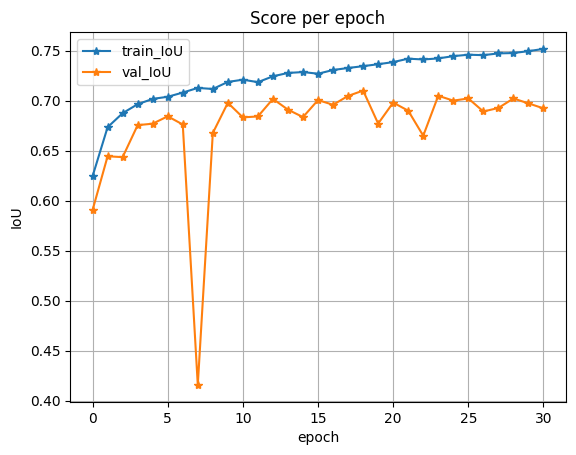

In [30]:
plt.plot(train_iou, label='train_IoU', marker='*')
plt.plot(val_iou, label='val_IoU',  marker='*')
plt.title('Score per epoch'); plt.ylabel('IoU')
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()

In [68]:
best_model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

best_model_checkpoint = torch.load('checkpoints/fpn_mobilenetv2_512im_bce_v2/epoch049_IOU(0.969)_bce_loss(0.0535).pth', map_location="cpu")
best_model.load_state_dict(best_model_checkpoint['state_dict'])
best_model.eval()

FPN(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1,

In [69]:
prep = get_preprocessing(preprocessing_fn)

In [70]:
test_dataset = Dataset(
    X_valid,
    y_valid,
    images_dir, 
    masks_dir,
    im_size=IM_SIZE,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
#     classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [71]:
valid_dataset = Dataset(
    X_valid,
    y_valid,
    images_dir,
    masks_dir,
    im_size=IM_SIZE,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
#     classes=CLASSES,
)

In [72]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

In [81]:
test_dataset_vis = Dataset(
    X_valid,
    y_valid,
    images_dir, 
    masks_dir
)

In [82]:
X_valid[5]

'20230225_124529.jpg'

In [83]:
for i in range(15):
    print(i)
    n = np.random.choice(len(test_dataset))
    print(X_valid[n])
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

0
20230225_125009.jpg
src/data/images/20230225_125009.jpg src/data/masks/20230225_125009.png


ValueError: axes don't match array